# Spatial Interaction Modelling calibration workbook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import numpy as np

## Setting up some spatial data

In [2]:
#Fetch a GeoJson of some district-level boundaries from the ONS Geoportal. First add the URL to an object
url = "http://geoportal.statistics.gov.uk/datasets/8edafbe3276d4b56aec60991cbddda50_2.geojson"
EW = gpd.read_file(url)

Check to make sure the boundaries have downloaded OK...

<AxesSubplot:>

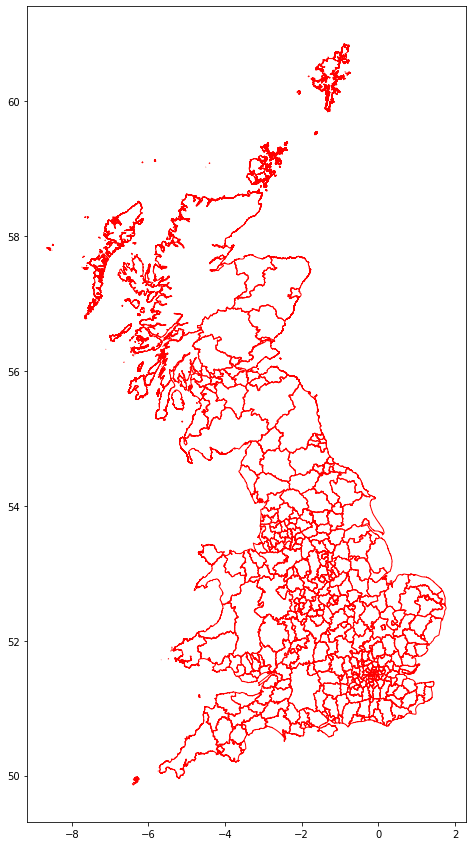

In [3]:
EW.plot(figsize = (10,15), facecolor = "None", edgecolor = "r")

In [4]:
EW.head(10)

,objectid,lad15cd,lad15nm,lad15nmw,st_areashape,st_lengthshape,geometry
0,1,E06000001,Hartlepool,,9.844169e+07,65270.302085,"POLYGON ((-1.26846 54.72612, -1.26858 54.72614..."
1,2,E06000002,Middlesbrough,,5.455358e+07,41055.846979,"POLYGON ((-1.25112 54.59153, -1.25173 54.59144..."
2,3,E06000003,Redcar and Cleveland,,2.538909e+08,101208.779781,"POLYGON ((-1.13633 54.64504, -1.13654 54.64510..."
3,4,E06000004,Stockton-on-Tees,,2.097308e+08,108085.159612,"POLYGON ((-1.31729 54.64480, -1.31756 54.64499..."
4,5,E06000005,Darlington,,1.974757e+08,107206.323036,"POLYGON ((-1.63768 54.61714, -1.63800 54.61720..."
5,6,E06000006,Halton,,9.032151e+07,60716.864614,"POLYGON ((-2.73037 53.39989, -2.73067 53.39994..."
6,7,E06000007,Warrington,,1.823836e+08,84154.518583,"POLYGON ((-2.49407 53.48010, -2.49410 53.48012..."
7,8,E06000008,Blackburn with Darwen,,1.370221e+08,65284.958201,"POLYGON ((-2.46850 53.78164, -2.46884 53.78175..."
8,9,E06000009,Blackpool,,4.315077e+07,36304.948644,"POLYGON ((-3.02048 53.85938, -3.02057 53.85940..."
9,10,E06000010,"Kingston upon Hull, City of",,8.149751e+07,45997.483017,"POLYGON ((-0.31613 53.81327, -0.31885 53.81288..."


For the time being let us extract London which corresponds to "E09" from the "lad15cd" column

In [5]:
London = EW[EW.lad15cd.str.contains("E09")]

<AxesSubplot:>

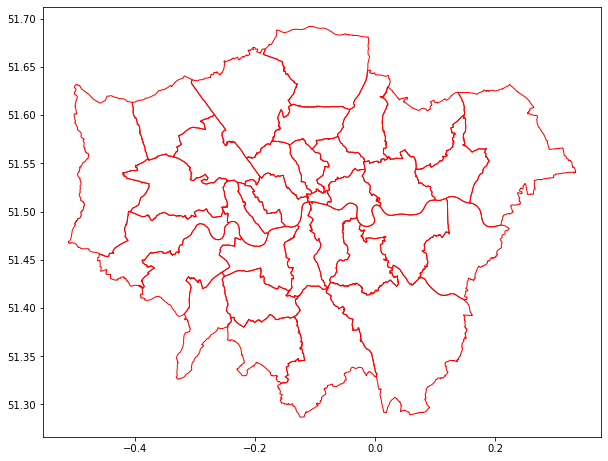

In [6]:
London.plot(figsize = (10,15), facecolor = "None", edgecolor = "r")

In [7]:
#look under the bonnet
London.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
London.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 33 entries, 293 to 325
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   objectid        33 non-null     int64   
 1   lad15cd         33 non-null     object  
 2   lad15nm         33 non-null     object  
 3   lad15nmw        33 non-null     object  
 4   st_areashape    33 non-null     float64 
 5   st_lengthshape  33 non-null     float64 
 6   geometry        33 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 2.1+ KB


## Calculting a distance matrix

Now we have a nice clean set of London Boundaries, let's extract some spatial data. Of course, the important spatial data for spatial interaction models relates to the cost of interaction between places and this is very frequently represented through distance...

If you look at the crs above, the boundaries are not in the British National Grid Projection, as we can see that the CRS is WGS84, indicating longitude and latitude coordinates. We need to change this to the British National grid so that our distances are in metres and not decimal degrees, then we need to generate a distance matrix.

C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<AxesSubplot:>

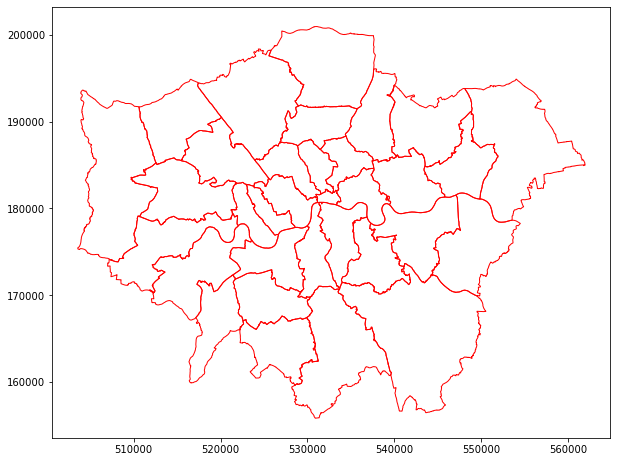

In [9]:
#transform london to BNG
London.to_crs("EPSG:27700", inplace = True)
#We can check that this has occured by plotting the results
London.plot(figsize = (10,15), facecolor = "None", edgecolor = "r")

In [10]:
#order it by borough code - *This step will be important later on*
London.sort_values(by=["lad15cd"], inplace = True)

#extract the centroids
London["Centroids"] = London.geometry.centroid

<ipython-input-10-f90886d99978>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  London.sort_values(by=["lad15cd"], inplace = True)
C:\Users\phili\anaconda3\envs\urbsim\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [11]:
London.set_index('lad15cd', inplace=True, drop=True)
#calculate distances from all borough centroids to all borough centroids
distances = London.rename_axis('Orig').Centroids.apply(lambda x: London.rename_axis('Dest').Centroids.distance(x)).stack().reset_index()
distances.rename(columns = {0:'Dist'}, inplace=True)
distances.sort_values(by=["Orig", "Dest"], inplace = True)
London.reset_index(inplace=True)

In [12]:
#Given that we have converted to the BNG already, this means that we could simply compute the Euclidean distance
#which can be done with this code
#uncomment if you wish

#drop any uncessary columns
#LDN_cent = London.drop(columns = ["objectid", "lad15nm", "lad15nmw", "st_areashape", "st_lengthshape", "geometry"])

#extract the x and y coordinates
#LDN_cent["x"] = LDN_cent["Centroids"].map(lambda p: p.x)
#LDN_cent["y"] = LDN_cent["Centroids"].map(lambda p: p.y) 

#you can now drop the centroids
#LDN_cent.drop(columns =[ "Centroids"], inplace = True)

#extract the distances for each possible pair
#distances = []
#for index1, row1 in LDN_cent.iterrows():
#    for index2, row2 in LDN_cent.iterrows():
#        #append the orig code, destination code and distance
#        distances.append([row1["lad15cd"], row2["lad15cd"], 
#                          ((float(row1["x"])-float(row2["x"]))**2 +(float(row1["y"])-float(row2["y"]))**2)**0.5])
        
#convert the resulting list into a dataframe        
#distances = pd.DataFrame.from_records(distances, columns = ["Orig", "Dest", "Dist"])

#sort by origin code and then destination code
#distances.sort_values(by=["Orig", "Dest"], inplace = True)

#check the results
#distances

## Flow data

The data we are going to use to test our spatial interaction models is with commuting data from the 2001 England and Wales Census. In the Census, there is a question which asks your home address and another which asks the location of your usual place of work, as well as the method of transport that you mainly use to conduct your commute. From this, estimates of commuter flows by transportation type for the whole country can be generated.

In this exercise, to save time, I have already downloaded some sample data which records the place (Borough) or residence and place (Borough) of work for all people living in London at the time of the 2001 Census. Borough level is quite coarse but it will suffice for demonstration purposes. If you would like to download your own commuting or migration flow data, then you should visit the Census Support Flow Data Service called wicid - https://wicid.ukdataservice.ac.uk/ - here you can download flows for a huge range of geographies from the 1981, 1991, 2001 and 2011 Censuses.

As well as flow data, I have also collected some additional data on income, the number of jobs in each borough in 2001 and the total population - we will uses these as destination atractiveness/mass term and origin emissiveness/mass term proxies in the models which follow.

In [13]:
#read in your London Commuting Data
cdata = pd.read_csv("https://www.dropbox.com/s/7c1fi1txbvhdqby/LondonCommuting2001.csv?raw=1")
#read in a lookup table for translating between old borough codes and new borough codes
CodeLookup = pd.read_csv("https://www.dropbox.com/s/h8mpvnepdkwa1ac/CodeLookup.csv?raw=1")
#read in some population and income data
popincome = pd.read_csv("https://www.dropbox.com/s/84z22a4wo3x2p86/popincome.csv?raw=1")

In [14]:
#add the new Borough code to the origin old Borough code and remove the uncessary columns
cdata = cdata.merge(CodeLookup, left_on = "OrigCode", right_on = "OldCode")
cdata.drop(columns = ["OldCode", "Label"], inplace = True)
cdata.rename(columns = {"NewCode": "OrigCodeNew"}, inplace = True)

#do the same with the destinations
cdata = cdata.merge(CodeLookup, left_on = "DestCode", right_on="OldCode")
cdata.drop(columns = ["OldCode", "Label"], inplace = True)
cdata.rename(columns = {"NewCode": "DestCodeNew"}, inplace = True)


In [15]:
#add the population income (here we will use the median income as it is a more reliable indicator and not 
#affected by skewness as much as average income might be)
popincome.drop(columns = ["label", "avg_income"], inplace = True)

#merge on the origins
cdata = cdata.merge(popincome, left_on = "OrigCodeNew", right_on ="code")
cdata.drop(columns = ["code"], inplace = True)
cdata.rename(columns={"pop":"Oi1_origpop", "med_income": "Oi2_origsal"}, inplace = True)

#do the same with the destination
cdata = cdata.merge(popincome, left_on = "DestCodeNew", right_on ="code")
cdata.drop(columns = ["code"], inplace = True)
cdata.rename(columns={"pop":"Dj1_destpop", "med_income": "Dj2_destsal"}, inplace = True)

In [16]:
#the data needs to be ordered by borough code, if it's not then we will run into problems when we try to merge the 
#distance data back in later
cdata.sort_values(by=["OrigCodeNew", "DestCodeNew"], inplace = True)

#reset the resulting index (important for later) when merging back together
cdata.reset_index(inplace=True)
cdata.drop(columns = ["index"], inplace=True)

To finish we need to add in our distance data that we generated earlier and create a new column of total flows that excludes the flows that occur within boroughs (we could keep the within-borough (intra-borough) flows in but they can cause problems so for now we will just exclude them).

In [17]:
#first we create a new total column which excludes intra-borough flow totals (we will set them
#to a very small number for reasons you will see later)
cdata["TotalNoIntra"] = cdata.apply(lambda x: 0 if x['OrigCode'] == x['DestCode'] else x['Total'], axis=1)

In [18]:
#set the number to a very small number
cdata["offset"]= cdata.apply(lambda x: 0.0000000001 if x['OrigCode'] == x['DestCode'] else 0, axis=1)

In [19]:
#add the distance column into the dataframe
cdata = cdata.merge(distances['Dist'], left_index=True, right_index=True)

Let's have a quick look at what the data now looks like

In [20]:
#look at the flows that originate from the city of London
cdata.head(33)

,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,Train,Bus,Taxi,...,Other,OrigCodeNew,DestCodeNew,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal,TotalNoIntra,offset,Dist
0,City of London,00AA,City of London,00AA,2059,432,120,53,50,31,...,41,E09000001,E09000001,12000,38300,12000,38300,0,1.000000e-10,0.000000
1,City of London,00AA,Barking and Dagenham,00AB,6,0,3,3,0,0,...,0,E09000001,E09000002,12000,38300,56000,16200,6,0.000000e+00,15995.126278
2,City of London,00AA,Barnet,00AC,14,0,11,0,0,0,...,0,E09000001,E09000003,12000,38300,159000,18700,14,0.000000e+00,13935.493783
3,City of London,00AA,Bexley,00AD,0,0,0,0,0,0,...,0,E09000001,E09000004,12000,38300,112000,18300,0,0.000000e+00,17359.785328
4,City of London,00AA,Brent,00AE,16,0,10,0,3,0,...,0,E09000001,E09000005,12000,38300,127000,16500,16,0.000000e+00,13119.643273
5,City of London,00AA,Bromley,00AF,0,0,0,0,0,0,...,0,E09000001,E09000006,12000,38300,164000,19100,0,0.000000e+00,18740.607277
6,City of London,00AA,Camden,00AG,335,0,104,10,28,0,...,0,E09000001,E09000007,12000,38300,101000,19800,335,0.000000e+00,5742.755690
7,City of London,00AA,Croydon,00AH,3,0,0,0,3,0,...,0,E09000001,E09000008,12000,38300,153000,18300,3,0.000000e+00,17701.559216
8,City of London,00AA,Ealing,00AJ,9,0,6,3,0,0,...,0,E09000001,E09000009,12000,38300,141000,17500,9,0.000000e+00,16581.739032
9,City of London,00AA,Enfield,00AK,6,0,0,0,0,0,...,0,E09000001,E09000010,12000,38300,128000,17500,6,0.000000e+00,15197.449727


This is nice but to make this demonstration easier, let's just select a small subset of these flows (we can come back to the whole dataset later on...)

In [21]:
#we will just select the first 7 boroughs by code
to_match = ["00AA", "00AB", "00AC", "00AD", "00AE", "00AF", "00AG"]

#subset the data by the 7 sample boroughs
#first the origins
cdatasub = cdata[cdata["OrigCode"].isin(to_match)]
#then the destinations
cdatasub = cdatasub[cdata["DestCode"].isin(to_match)]

#now chop out the intra-borough flows
cdatasub = cdatasub[cdata["OrigCode"] != cdata["DestCode"]]

#we now want to re-order so that OrigCodeNEw, DestCodeNew and TotalNoIntra are the first three columns
beg = ["OrigCodeNew", "DestCodeNew", "TotalNoIntra"] 
cols = beg + [col for col in cdatasub.columns.tolist() if col not in beg]
#re index the columns
cdatasub = cdatasub.reindex(columns = cols)

<ipython-input-21-36878368c2de>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cdatasub = cdatasub[cdata["DestCode"].isin(to_match)]
<ipython-input-21-36878368c2de>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cdatasub = cdatasub[cdata["OrigCode"] != cdata["DestCode"]]


In [22]:
cdatasub.head(10)

,OrigCodeNew,DestCodeNew,TotalNoIntra,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,...,Motobike,Bicycle,Walk,Other,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal,offset,Dist
1,E09000001,E09000002,6,City of London,00AA,Barking and Dagenham,00AB,6,0,3,...,0,0,0,0,12000,38300,56000,16200,0.0,15995.126278
2,E09000001,E09000003,14,City of London,00AA,Barnet,00AC,14,0,11,...,0,0,3,0,12000,38300,159000,18700,0.0,13935.493783
3,E09000001,E09000004,0,City of London,00AA,Bexley,00AD,0,0,0,...,0,0,0,0,12000,38300,112000,18300,0.0,17359.785328
4,E09000001,E09000005,16,City of London,00AA,Brent,00AE,16,0,10,...,0,0,3,0,12000,38300,127000,16500,0.0,13119.643273
5,E09000001,E09000006,0,City of London,00AA,Bromley,00AF,0,0,0,...,0,0,0,0,12000,38300,164000,19100,0.0,18740.607277
6,E09000001,E09000007,335,City of London,00AA,Camden,00AG,335,0,104,...,0,15,150,0,12000,38300,101000,19800,0.0,5742.755690
33,E09000002,E09000001,3641,Barking and Dagenham,00AB,City of London,00AA,3641,0,1444,...,63,9,11,0,56000,16200,12000,38300,0.0,15995.126278
35,E09000002,E09000003,194,Barking and Dagenham,00AB,Barnet,00AC,194,0,29,...,4,0,0,0,56000,16200,159000,18700,0.0,25100.158361
36,E09000002,E09000004,96,Barking and Dagenham,00AB,Bexley,00AD,96,0,6,...,0,0,0,0,56000,16200,112000,18300,0.0,9264.794308
37,E09000002,E09000005,178,Barking and Dagenham,00AB,Brent,00AE,178,0,47,...,0,0,3,0,56000,16200,127000,16500,0.0,27855.911025


Now we can try plotting the flow lines

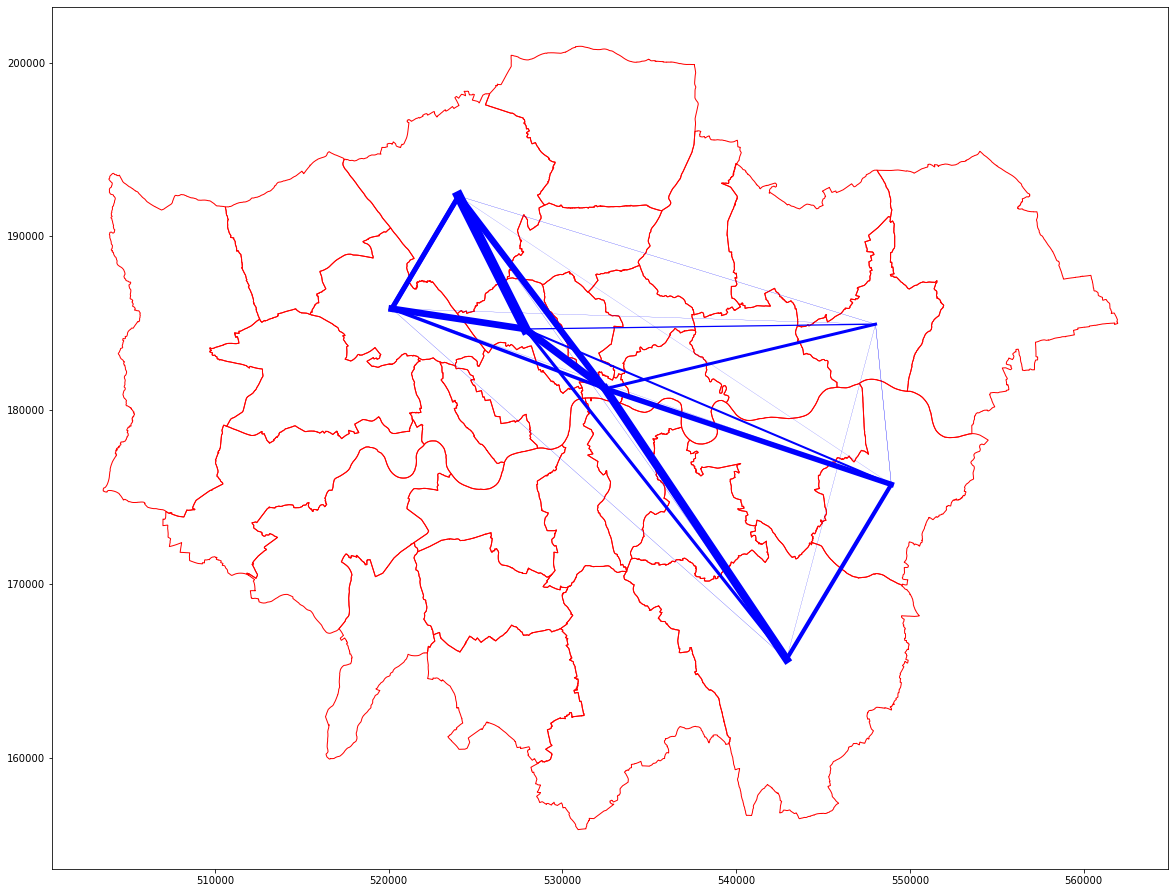

In [23]:
#plot the base map
London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")

#iterate over each pair
for index, row in cdatasub.iterrows():
    #get the x coordinates
    x1 = [London[London["lad15cd"] == row["OrigCodeNew"]]["Centroids"].x, London[London["lad15cd"] == row["DestCodeNew"]]["Centroids"].x]
    #get the y coordinates
    y1 = [London[London["lad15cd"] == row["OrigCodeNew"]]["Centroids"].y, London[London["lad15cd"] == row["DestCodeNew"]]["Centroids"].y]
    #plot the line between the x and y coordinates with width reflecting the number of flows
    plt.plot(x1, y1, linewidth = row["TotalNoIntra"]/max(cdatasub["TotalNoIntra"])*10, color = "Blue")
    
#be careful when working with large amounts of data

Or, if you really want to be cool - on a leaflet map. See [here](https://python-visualization.github.io/folium/) for more details on this.

In [24]:
import folium

#set the base map to locate on London
my_map =folium.Map(location = [51.5, 0.1278], zoom_start = 10)

#transform to WGS84
London_WGS = London.to_crs("EPSG:4326")
London_WGS["x"] = London_WGS.geometry.centroid.map(lambda p: p.y)
London_WGS["y"]= London_WGS.geometry.centroid.map(lambda p: p.x)

#plot in leaflet
#This is done using the folium library
#iterate over each pair
for index, row in cdatasub.iterrows():
    #get the first set of coordinates
    x1 = [London_WGS[London_WGS["lad15cd"]==row["OrigCodeNew"]]["x"].values[0],
       London_WGS[London_WGS["lad15cd"]==row["OrigCodeNew"]]["y"].values[0]]
    #get the second set of coordinates
    x2 = [ London_WGS[London_WGS["lad15cd"]==row["DestCodeNew"]]["x"].values[0],
           London_WGS[London_WGS["lad15cd"]==row["DestCodeNew"]]["y"].values[0]]
    #create a list of the coordinates
    coords = [x1, x2]
    #add a polyline with size reflective of the number of people
    folium.vector_layers.PolyLine(coords, weight = row["TotalNoIntra"]/max(cdatasub["TotalNoIntra"])*20, opacity = 0.5
                                 ).add_to(my_map)
                                
#plot the map                                
my_map

<ipython-input-24-c0032c5a20be>:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  London_WGS["x"] = London_WGS.geometry.centroid.map(lambda p: p.y)
<ipython-input-24-c0032c5a20be>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  London_WGS["y"]= London_WGS.geometry.centroid.map(lambda p: p.x)


In [25]:
import numpy as np
#now we can create a pivot table to turn paired list into a matrix, and compute the margin as well
cdatasubmat = pd.pivot_table(cdatasub, values ="TotalNoIntra", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


Now that we have set everything up its

## Modellin' Time!

In explaining how to run and calibrate spatial interaction models in Python, Mike Batty's notation will be used for spatial interaction models. An alternative for this would be using Taylor Oshan's notation in his excellent primer on interaction models in Python. The paper is well worth a read and can be found [here](http://openjournals.wu.ac.at/region/paper_175/175.html)

Below is the classic multiplicate gravity model:

\begin{equation} \label{eq:1} \tag{1}
T_{ij} = k \frac{O_i^\alpha  D_j^\gamma}{ d_{ij}^\beta}
\end{equation}

This gravity model can be written in the form more familiar from [Wilson's 1971 paper](http://journals.sagepub.com/doi/abs/10.1068/a030001) 

\begin{equation} \label{eq:2} \tag{2}
T_{ij} = k O_i^\alpha  D_j^\gamma  d_{ij}^{-\beta}
\end{equation}

<b>This model just says that the flows between an origin and destination are proportional to the product of the mass of the origin and destination and inversley proportional to the distance between them.
    
As origin and destination masses increase, flows increase, but as distance increases, flows decrease, and vice versa.</b>

- Where $T_{ij}$ is the transition or flow, $T$, between origin $i$ (always the rows in a matrix) and destination $j$ (always the columns in a matrix). If you are not overly familiar with matrix notation, the i and j are just generic indexes to allow us to refer to any cell in the matrix more generally.
- $O$ is a vector (a 1 dimensional matrix - or, if you like, a single line of numbers) of origin attributes which relate to the emissiveness of all origins in the dataset, $i$ - in our sample dataset, we have a vector of origin populations (which I have called Oi1_origpop) and a vector of origin average salaries (which I have called Oi2_origsal) in 2001
- $D$ is a vector of desination of attributes relating to the attractivenss of all destinations in the dataset, $j$ - in our sample dataset, we have a vector of destination populations (which I have called Dj1_destpop) and a vector of destination average salaries (which I have called Dj2_destsal) in 2001
- $d$ is a matrix of costs relating to the flows between $i$ and $j$ - in our case the cost is the distance and it is called ‘dist’ in our dataset.
- $k$, $\alpha$, $\gamma$ and $β$ are all the model parameters to be estimated

$k$ is a constant of proportionality. Given that all flows estimated by the model will sum to any observed flow data used to calibrate the parameters:

\begin{equation} \label{eq:3} \tag{3}
k = \frac{T}{\sum_i \sum_j O_i^\alpha  D_j^\gamma  d_{ij}^{-\beta}}
\end{equation}

and $T$ is the sum of our matrix of observed flows or:

\begin{equation} \label{eq:4} \tag{4}
T= \sum_i \sum_j T_{ij}
\end{equation}

In English, this is just the sum of all observed flows divided by the sum of all of the other elements in the model.


## How good is my model?

So looking at the two matrices above you can see that in some cases the flow estimates aren't too bad (Barking and Dagenham to Barnet for example, but in others they are pretty rubbish (Camden to the City of London?). Whilst it's OK to eyeball small flow matrics like this, when you have much larger matrices we need another solution ...

### Testing the "Goodness-of-fit"

Yes, that’s what it’s called - I know, it doesn’t sound correct, but goodness-of-fit is the correct term for checking how well your model estimates match up with your observed flows.

So how do we do it?

Well… there are a number of ways but perhaps the two most common are to look at the coefficient of determination ($r^2$) or the Square Root of Mean Squared Error (RMSE). You’ve probably come across $r^2$ before if you have fitted a linear regression model, but you may not have come across RMSE. There are other methods and they all do more or less the same thing, which is essentially to compare the modelled estimates with the real data. $r^2$ is popular as it is quite intuitive and can be compared across models. RMSE is less intuitive, but some argue that it is better for comparing changes to the same model. Here we’ll do both…

### R-Squared
 
$r^2$ is the square of the correlation coefficient, $r$

For our sample data, we can calculate this very easily using a little function.


In [26]:
import scipy.stats

def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

Using this function we get a value of around 0.50, or around 50%. This tells us that our model accounts for about 50% of the variation of flows in the system. Not bad, but not brilliant either.

### Root Mean Squared Error (RMSE)

We can use a similar simple function to calcualte the RMSE for our data

In [27]:
from math import sqrt

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

The figure that is produced by the RMSE calcaultion is far less intuitive than the $r^2$ and this is mainly because it very much depends on things like the units the data are in and the volume of the data. It can't be used to compared different models run using different data sets. However, it is good for assessing whether changes to the model result in improvements. The closer to 0 the RMSE value, the better the model.

So how can we start to improve our fit...?

### The Poisson Regression Spatial Interaction Model

So, we can now re-specify Equation 5 as a Poisson Regression model. Basically, we are assuming that the flows follow a Poisson distribution, such that the expected value $\lambda_{ij}$ verifies:

\begin{equation} \label{eq:6} \tag{6}
\lambda_{ij} = \exp (K + \alpha \ln O_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

What this model says is that $\lambda_{ij}$ (our independent variable - the estimate of $T_{ij}$) is <i>logarithmically linked </i> to (or modelled by) a linear combination of the logged independent variables in the model. 

Now we have Equation 6 at our disposal, we can use a Poisson regression model to produce estimated of $k$, $\alpha$, $\gamma$ and $\beta$ - or put another way, we can use the rgeression model to calibrate our parameters.

So, let's have a go at doing it!

It is very straightforward to run a Poisson regression model in Python using the `glm` function in the Statsmodel.api library. In practical terms, running a GLM model is no different to running a standard regression model using `lm`. If you want to find more details about this you can visit the statsmodel api documentation [here](https://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.html#statsmodels.genmod.generalized_linear_model.GLM) and [here](https://www.statsmodels.org/stable/examples/notebooks/generated/glm_formula.html) or for more information about the Poisson regression application you can read other articles on the internet such as this [medium article](https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958). If you delve far enough into the depths of what GLM does, you will find that the parameters are calibrated though an ‘iteratively re-weighted least squares’ algorithm. This algorithm does exactly the sort of job I described earlier, it fits lots of lines to the data, continually adjusting the parameters and then seeing if it can minimise the error between the observed and expected values using some goodness-of-fit measure.

These sorts of algorithms have been around for years and are very well established so it makes sense to make use of them rather than trying to re-invent the wheel ourselves. So here we go…

In [28]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

#create the formula
formula = 'Total ~ np.log(Oi1_origpop) + np.log(Dj2_destsal) + np.log(Dist)'

#run the regression
uncosim = smf.glm(formula = formula, data=cdatasub, family=sm.families.Poisson()).fit()


It’s a simple as that - runs in a matter of milliseconds. You should be able to see how the `glm` code corresponds to Equation 6.

`Total` = $T_{ij}$ = $\lambda_{ij}$

`~` means ‘is modelled by’

`log_Oi1_origpop` = $\ln O_i$

`log_Dj2_destsal` = $\ln D_j$

`log_dist` = $\ln d_{ij}$

`family=sm.families.Poisson()`means that we are using a Poisson regression model (the link is always log with a Poisson model) where the left-hand side of the model equation is logarithmically linked to the variables on the right-hand side.

So what comes out of the other end?

Well, we can use the `summary()` function to have a look at the model parameters:

In [29]:
#extract the summary of the constrained model
print(uncosim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       38
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23200.
Date:                Fri, 12 Mar 2021   Deviance:                       46086.
Time:                        08:22:47   Pearson chi2:                 4.69e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -15.8084    

We can see from the summary that the Poisson regression has calibrated all 4 parameters for us and these appear under the ‘estimate’ column:

$K$ (intercept) = -15.8084. Recall $K=\ln k$, hence $k$ can NEVER be negative!

$\alpha$ = 1.7558

$\gamma$ = 1.6472

and $\beta$ = 1.4079 recall in equation (6) there is a negative sign in front of $\beta$. 

We can also see from the other outputs that all variables are highly significant (P>|z| < 0.01), with the z-scores revealing that distance has the most influence on the model (as we might have expected from the scatter plots we produced earlier which showed that distance had by far the strongers correlation with commuting flows).

These parameters are not too far away from our initial guesses of $\alpha$ = 1, $\gamma$ = 1 and $\beta$ = 2, but how do the estimates compare?

One way to calculate the estimates is to plug all of the parameters back into Equation 6 like this:

In [30]:
#first assign the parameter values from the model to the appropriate variables
K = uncosim.params[0]
alpha = uncosim.params[1]
gamma = uncosim.params[2]
beta = -uncosim.params[3]

#now plug everything back into the Equation 6 model ... 
#be careful with the negative signing of the parameter beta
cdatasub["unconstrainedEst1"] = np.exp(K + alpha*np.log(cdatasub["Oi1_origpop"])
                                       + gamma*np.log(cdatasub["Dj2_destsal"]) -
                                      beta*np.log(cdatasub["Dist"]))

#or we can just extract the results from the actual poisson regression and apply them to the data
predictions = uncosim.get_prediction()
predictions_summary_frame = predictions.summary_frame()
cdatasub["fitted"] = predictions_summary_frame["mean"]

In [31]:
#round the numbers so that we don't get a half of a person
cdatasub["unconstrainedEst1"] = round(cdatasub["unconstrainedEst1"], 0)
#convert to integers
cdatasub["unconstrainedEst1"] = cdatasub["unconstrainedEst1"].astype(int)
#check that the sum of these estimates make sense
sum(cdatasub["unconstrainedEst1"])

93803

In [32]:
#turn it into a little matrix and have a look at your handy work
cdatasubmat2 = cdatasub.pivot_table(values ="unconstrainedEst1", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat2

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,206.0,808.0,145.0,294.0,308.0,1264.0,3025
Barnet,1015.0,NaN,968.0,5683.0,919.0,6422.0,9587.0,24594
Bexley,2231.0,542.0,NaN,430.0,2099.0,869.0,3803.0,9974
Brent,591.0,4707.0,636.0,NaN,686.0,4957.0,7034.0,18611
Bromley,1480.0,937.0,3820.0,844.0,NaN,1567.0,6670.0,15318
Camden,623.0,2635.0,637.0,2455.0,630.0,NaN,15056.0,22036
City of London,20.0,32.0,22.0,28.0,22.0,121.0,NaN,245
All,5960.0,9059.0,6891.0,9585.0,4650.0,14244.0,43414.0,93803


In [33]:
#compare it to the actual flows
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


We can see here that some of the estimates have improved such as Barking and Dagenham to Barnet is now even closer and is within 10% of the actual flow, while the Barking and Dagenham to Bexley predicted flow has converged but is still far out.

Therefore the $1,000,000 question is - has calibrating the parameters improved the model...?

In [34]:
CalcRSqaured(cdatasub["Total"], cdatasub["unconstrainedEst1"])

0.6725599227081145

In [35]:
CalcRMSE(cdatasub["Total"], cdatasub["unconstrainedEst1"])

1892.615

## Origin constrained

\begin{equation} \label{eq:1} \tag{1}
T_{ij} = A_i O_i D_j^\gamma d_{ij}^{-\beta}
\end{equation}

Where

\begin{equation} \label{eq:2} \tag{2}
O_i = \sum_j T_{ij}
\end{equation}

and

\begin{equation} \label{eq:3} \tag{3}
A_i = \frac{1}{\sum_j D_j^\gamma d_{ij}^{-\beta}}
\end{equation}

In the production-constrained model, $O_i$ does not have a parameter as it is a known constraint. $A_i$ is known as a <i>balancing factor</i> and is a vector of values which relate to each origin, $i$, which do the equivalent job to $k$ in the unconstrained/total constrained model but ensure that flow estimates from each origin sum to the known totals, $O_i$ rather than just the overall total.

We set about re-specifying the Production Constrained model as a Poisson regression model in exactly the same way as we did before. We need to take logs of the right-hand side of the equation and assume that these are logarithmically linked to the Poisson distributed mean ($\lambda_{ij}$) of the $T_{ij}$ variable. As such, Equation (1) becomes:

\begin{equation} \label{eq:4} \tag{4}
\lambda_{ij} = \exp (\alpha_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

In Equation (4) $\alpha_i$ is the equivalent of the vector of balancing factors $A_i$, but in regression /log-linear modelling terminology can also be described as either <b>dummy variables</b> or <b>fixed effects</b>

In [36]:
#create the formula
formula = 'Total ~ OrigCodeNew + np.log(Dj2_destsal) + np.log(Dist)'

#run the regression
prodsim = smf.glm(formula = formula, data=cdatasub, family=sm.families.Poisson()).fit()

print(prodsim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       33
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14977.
Date:                Fri, 12 Mar 2021   Deviance:                       29640.
Time:                        08:22:48   Pearson chi2:                 2.89e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [37]:
pred_res = prodsim.mu
cdatasub["prodsimest1"] = np.round(pred_res, 0)

In [38]:
CalcRSqaured(cdatasub["Total"], cdatasub["prodsimest1"])

0.8127672271674717

In [39]:
CalcRMSE(cdatasub["Total"], cdatasub["prodsimest1"])

1400.714

checking to see whether the origin constraints have held, they have:

In [40]:
#turn it into a little matrix and have a look at your handy work
cdatasubmat3 = cdatasub.pivot_table(values ="prodsimest1", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat3

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,222.0,1926.0,136.0,385.0,405.0,2602.0,5676.0
Barnet,461.0,NaN,401.0,6859.0,361.0,7525.0,9854.0,25461.0
Bexley,4020.0,402.0,NaN,299.0,3336.0,818.0,5811.0,14686.0
Brent,222.0,5357.0,233.0,NaN,256.0,5631.0,6810.0,18509.0
Bromley,1268.0,571.0,5271.0,519.0,NaN,1243.0,8458.0,17330.0
Camden,103.0,922.0,100.0,884.0,96.0,NaN,9663.0,11768.0
City of London,18.0,32.0,19.0,28.0,17.0,257.0,NaN,371.0
All,6092.0,7506.0,7950.0,8725.0,4451.0,15879.0,43198.0,93801.0


In [41]:
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


# Linear regression

In order to calibrate the model by regression it must be in a linear format which takes the form:

\begin{equation}
y = \alpha_0 + \alpha_1 x_1 + \alpha_2 x_2 + ... \alpha_h x_h 
\end{equation}

Where y is the dependent variable and the x's are the independent variable. Since we are focused on OLS linear regression, this means that we need to the model in a full linear format as we don't have the link function like we do in Poisson regression.

## Total constrained

The unconstrained model takes the format:

\begin{equation}
T_{ij} = k v_i^\alpha w_j^\gamma d_{ij}^\beta
\end{equation}

Then to linearise the model we can take logarithms of both sides of the equation so that this becomes:

\begin{equation}
\ln T_{ij} = \ln k + \alpha  \ln v_i + \gamma \ln w_j - \beta ln d_{ij}
\end{equation}

If the assumptions of OLS regression are met then $\alpha'$, $\gamma'$ and $\beta'$ re unbiased and consistent estimates of $\alpha$, $\gamma$ and $\beta$ but $\exp \ln k$ is a biased estimate of k. In reality, k will always be underestimated when obtained by OLS unless the model fits perfectly. This results in total predicted flows being less than actual flows, thus the total constraint is not held. This a more accurate estimate of k, k'(new) should be obtained after the regression by:

\begin{equation}
k_{new} = k_{old} * \frac{\sum_i \sum_j T_{ij}}{\sum_i \sum_j T_{ij}'}
\end{equation}

This is implemented as follows:

In [42]:
#linear regression exploration

cdatasub["Total_offset"] = cdatasub["Total"] + 0.01

formula = "np.log(Total_offset) ~ np.log(Oi1_origpop) + np.log(Dj2_destsal) + np.log(Dist)"

mod = smf.ols(formula = formula, data = cdatasub).fit()

print(mod.summary())

                             OLS Regression Results                             
Dep. Variable:     np.log(Total_offset)   R-squared:                       0.704
Model:                              OLS   Adj. R-squared:                  0.681
Method:                   Least Squares   F-statistic:                     30.20
Date:                  Fri, 12 Mar 2021   Prob (F-statistic):           3.71e-10
Time:                          08:22:48   Log-Likelihood:                -82.020
No. Observations:                    42   AIC:                             172.0
Df Residuals:                        38   BIC:                             179.0
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept     

The results are then extracted as:

In [43]:
res = np.exp(mod.predict())
res = np.round(res, 0)
res

array([1.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
       3.9000e+01, 7.8300e+02, 2.5000e+01, 3.6000e+02, 1.3000e+01,
       5.0000e+01, 5.5000e+01, 1.4647e+04, 2.0700e+02, 1.8600e+02,
       5.9030e+03, 1.6700e+02, 7.3130e+03, 3.4070e+03, 1.3490e+03,
       8.5000e+01, 5.5000e+01, 1.1720e+03, 2.1000e+02, 9.9760e+03,
       9.0000e+01, 5.0080e+03, 1.0200e+02, 1.1800e+02, 5.4970e+03,
       7.0180e+03, 4.1900e+02, 1.6900e+02, 2.6100e+03, 1.4000e+02,
       4.5600e+02, 5.4774e+04, 1.2500e+02, 2.0230e+03, 1.2800e+02,
       1.7920e+03, 1.2500e+02])

The k value is then updated following the methodology set out in Fotheringham and O'Kelly (1988):

In [44]:
k_old = np.exp(mod.params[0])
k_new = k_old * (sum(cdatasub["Total"])/sum(res))

Other parameters are then extracted

In [45]:
alpha = mod.params[1]
gamma = mod.params[2]
beta = mod.params[3]

The model is then applied:

In [46]:
pred_res = np.exp(np.log(k_new) + alpha*np.log(cdatasub["Oi1_origpop"]) +
                 gamma * np.log(cdatasub["Dj2_destsal"]) + beta*np.log(cdatasub["Dist"]))

pred_res = np.round(pred_res, 0)

The total constraint is explored:

In [47]:
print(sum(cdatasub["Total"]))
print(sum(pred_res))

93802
93803.0


We can then see how this manifests itself in terms of the predicted flows against the actual flows:

In [48]:
cdatasub["OLS_est"] = pred_res

cdatasubmat4 = cdatasub.pivot_table(values ="OLS_est", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat4

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,19.0,267.0,10.0,37.0,40.0,580.0,953.0
Barnet,153.0,NaN,138.0,4373.0,124.0,5419.0,10852.0,21059.0
Bexley,999.0,63.0,NaN,41.0,868.0,156.0,2524.0,4651.0
Brent,67.0,3711.0,76.0,NaN,87.0,4073.0,7391.0,15405.0
Bromley,310.0,125.0,1934.0,104.0,NaN,338.0,5199.0,8010.0
Camden,92.0,1499.0,95.0,1328.0,92.0,NaN,40583.0,43689.0
City of London,1.0,2.0,1.0,2.0,1.0,29.0,NaN,36.0
All,1622.0,5419.0,2511.0,5858.0,1209.0,10055.0,67129.0,93803.0


In [49]:
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


In [50]:
print(CalcRSqaured(cdatasub["Total"], pred_res))
print(CalcRMSE(cdatasub["Total"], pred_res))

0.31999318608527366
5311.043


## Origin constrained

The production constrained model takes the form:

\begin{equation}
T_{ij} = A_i O_i W_j^\gamma d_{ij}^\beta
\end{equation}

Where:

\begin{equation}
A_i = \frac{1}{\sum_j W_j^\gamma d_{ij}^\beta}
\end{equation}

For this, Fotheringham and O'Kelly (1998) simplify this to:

\begin{equation}
\ln T_{ij} = k_i + \sum_h \alpha_h [ f_h (x_{ijh}) ]
\end{equation}

Whereby $k_i$ is an origin specific constant term (as noted in Cesario 1975b) and $\sum_h \alpha_h [ f_h (x_{ijh}) ]$ are the other independent variables and the function form.

The following implementation is based on the assumption that if $k_i$ is an origin specific constant term (cesario 1975) then the same post-regression manipulation as before needs to be undertaken for the constraints to hold, but that this is done on each origin specific term. Thus:


\begin{equation}
k_{inew} = k_{iold} * \frac{\sum_j T_{ij}}{\sum_j T_{ij}'}
\end{equation}


In [52]:
#linear regression exploration
#linear regression exploration
cdatasub["Total_offset"] = cdatasub["Total"] + 0.001

formula = "np.log(Total_offset) ~ OrigCodeNew + np.log(Dj2_destsal) + np.log(Dist) -1"

mod = smf.ols(formula = formula, data = cdatasub).fit()

print(mod.summary())

                             OLS Regression Results                             
Dep. Variable:     np.log(Total_offset)   R-squared:                       0.728
Model:                              OLS   Adj. R-squared:                  0.662
Method:                   Least Squares   F-statistic:                     11.05
Date:                  Fri, 12 Mar 2021   Prob (F-statistic):           2.02e-07
Time:                          08:22:48   Log-Likelihood:                -84.956
No. Observations:                    42   AIC:                             187.9
Df Residuals:                        33   BIC:                             203.6
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
OrigCode

Extract the origin specific parameters for the model:

In [53]:
#We can do this by pulling out the paramaetr values
coefs = pd.DataFrame(mod.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i2", "index":"coef"}, inplace = True)
to_repl = ["(OrigCodeNew)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
cdatasub = cdatasub.merge(coefs, left_on="OrigCodeNew", right_on="coef", how = "left")
cdatasub.drop(columns = ["coef"], inplace = True)
#check this has worked
cdatasub.head()

<ipython-input-53-53816d92f755>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,OrigCodeNew,DestCodeNew,TotalNoIntra,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,...,Dj1_destpop,Dj2_destsal,offset,Dist,unconstrainedEst1,fitted,prodsimest1,Total_offset,OLS_est,alpha_i2
0,E09000001,E09000002,6,City of London,00AA,Barking and Dagenham,00AB,6,0,3,...,56000,16200,0.0,15995.126278,20,20.489614,18.0,6.001,1.0,6.525655
1,E09000001,E09000003,14,City of London,00AA,Barnet,00AC,14,0,11,...,159000,18700,0.0,13935.493783,32,31.512550,32.0,14.001,2.0,6.525655
2,E09000001,E09000004,0,City of London,00AA,Bexley,00AD,0,0,0,...,112000,18300,0.0,17359.785328,22,22.318713,19.0,0.001,1.0,6.525655
3,E09000001,E09000005,16,City of London,00AA,Brent,00AE,16,0,10,...,127000,16500,0.0,13119.643273,28,27.914739,28.0,16.001,2.0,6.525655
4,E09000001,E09000006,0,City of London,00AA,Bromley,00AF,0,0,0,...,164000,19100,0.0,18740.607277,22,21.502039,17.0,0.001,1.0,6.525655


In [54]:
beta = mod.params[-1]
gamma = mod.params[-2]

Create estimates for the model based on the regression outputs:

In [55]:
cdatasub["OLS2_est"] = round(np.exp(cdatasub["alpha_i2"]+
                 gamma * np.log(cdatasub["Dj2_destsal"]) + beta*np.log(cdatasub["Dist"])),0)

From these outputs we can see that the constraints haven't held:

In [57]:
cdatasubmat3 = cdatasub.pivot_table(values ="OLS2_est", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat3

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,90.0,2435.0,46.0,206.0,219.0,2604.0,5600.0
Barnet,101.0,NaN,77.0,6028.0,64.0,6302.0,6703.0,19275.0
Bexley,5059.0,142.0,NaN,97.0,3495.0,406.0,5624.0,14823.0
Brent,45.0,5220.0,45.0,NaN,51.0,5465.0,5151.0,15977.0
Bromley,671.0,185.0,5472.0,171.0,NaN,586.0,7601.0,14686.0
Camden,40.0,1027.0,36.0,1028.0,33.0,NaN,24877.0,27041.0
City of London,0.0,1.0,0.0,1.0,0.0,19.0,NaN,21.0
All,5916.0,6665.0,8065.0,7371.0,3849.0,12997.0,52560.0,97423.0


In [58]:
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


Thus, we transform each origin specific parameter to make the coefficients hold post-regression:

In [59]:
coefs_alpha = coefs[coefs["coef"].str.contains("E")]

In [60]:
def alpha_update(row):
    orig = row["coef"]
    alpha_old = np.exp(row["alpha_i2"])
    actual = sum(cdatasub[cdatasub["OrigCodeNew"] == orig]["Total"])
    pred = sum(cdatasub[cdatasub["OrigCodeNew"] == orig]["OLS2_est"])
    alpha_new = alpha_old*actual/pred
    return alpha_new
    
alpha_update = coefs_alpha.apply(alpha_update, axis = 1)

In [61]:
coefs_alpha["alpha_i3"] = alpha_update

<ipython-input-61-c328e9928c01>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefs_alpha["alpha_i3"] = alpha_update


In [62]:
cdatasub = cdatasub.merge(coefs_alpha[["coef", "alpha_i3"]], left_on="OrigCodeNew", right_on="coef", how = "left")
cdatasub.drop(columns = ["coef"], inplace = True)
#check this has worked
cdatasub.head()

,OrigCodeNew,DestCodeNew,TotalNoIntra,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,...,offset,Dist,unconstrainedEst1,fitted,prodsimest1,Total_offset,OLS_est,alpha_i2,OLS2_est,alpha_i3
0,E09000001,E09000002,6,City of London,00AA,Barking and Dagenham,00AB,6,0,3,...,0.0,15995.126278,20,20.489614,18.0,6.001,1.0,6.525655,0.0,12056.205339
1,E09000001,E09000003,14,City of London,00AA,Barnet,00AC,14,0,11,...,0.0,13935.493783,32,31.512550,32.0,14.001,2.0,6.525655,1.0,12056.205339
2,E09000001,E09000004,0,City of London,00AA,Bexley,00AD,0,0,0,...,0.0,17359.785328,22,22.318713,19.0,0.001,1.0,6.525655,0.0,12056.205339
3,E09000001,E09000005,16,City of London,00AA,Brent,00AE,16,0,10,...,0.0,13119.643273,28,27.914739,28.0,16.001,2.0,6.525655,1.0,12056.205339
4,E09000001,E09000006,0,City of London,00AA,Bromley,00AF,0,0,0,...,0.0,18740.607277,22,21.502039,17.0,0.001,1.0,6.525655,0.0,12056.205339


Redo the regression with the updated alpha parameter where we can see that the origin constraints have just about held (although this is very sensitive to the origin parameter).

In [63]:
cdatasub["OLS3_est"] = round(np.exp(np.log(cdatasub["alpha_i3"])+
                 gamma * np.log(cdatasub["Dj2_destsal"]) + beta*np.log(cdatasub["Dist"])),0)

In [64]:

#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
cdatasubmat5 = cdatasub.pivot_table(values ="OLS3_est", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat5

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,92.0,2467.0,47.0,209.0,222.0,2639.0,5676.0
Barnet,134.0,NaN,101.0,7963.0,84.0,8325.0,8855.0,25462.0
Bexley,5012.0,141.0,NaN,96.0,3463.0,403.0,5572.0,14687.0
Brent,52.0,6047.0,52.0,NaN,59.0,6330.0,5967.0,18507.0
Bromley,792.0,219.0,6457.0,202.0,NaN,691.0,8969.0,17330.0
Camden,17.0,447.0,16.0,447.0,14.0,NaN,10827.0,11768.0
City of London,6.0,14.0,6.0,13.0,6.0,328.0,NaN,373.0
All,6013.0,6960.0,9099.0,8768.0,3835.0,16299.0,42829.0,93803.0


In [65]:
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


In [66]:
print(CalcRSqaured(cdatasub["Total"], cdatasub["OLS3_est"]))
print(CalcRMSE(cdatasub["Total"], cdatasub["OLS3_est"]))

0.7986938888955637
1489.074


In [67]:
#s_2 = sum((np.log(cdatasub["Total_offset"]) - gamma - beta*np.log(cdatasub["Dist"]))**2)/(len(cdatasub)-2)

In [68]:
#s_2

In [69]:
#cdatasub["OLS4_est"] = round(np.exp(np.log(cdatasub["alpha_i2"])+
#                 gamma * np.log(cdatasub["Dj2_destsal"]) + beta*np.log(cdatasub["Dist"]) + (s_2/2)),0)

In [70]:
#cdatasubmat3 = cdatasub.pivot_table(values ="OLS4_est", index="Orig", columns = "Dest",
#                            aggfunc=np.sum, margins=True)
#cdatasubmat3

IndentationError: unexpected indent (<ipython-input-70-6a3059e4e42d>, line 2)